In [1]:
import gzip
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import string
import random
import string
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error as MSE
import json

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
data = []
f = gzip.open('renttherunway_final_data.json.gz', 'r')

ratings = []
ages = []
weights = []
heights = []

fits = defaultdict(int)
fit_to_float = {"small": 0, "fit": 1, "large": 2}

for l in f:
    try:
        x = eval(l)

        fits[x['fit']] += 1
        
        # Data cleaning: convert height, weight, and rating to integer types
        x['rating'] = int(x['rating'])
        ratings.append(x['rating'])

        if 'age' in x:
            x['age'] = int(x['age'])
            ages.append(x['age'])
        if 'weight' in x:
            x['weight'] = int(x['weight'][:-3])
            weights.append(x['weight'])
        if 'height' in x:
            feet = int(x['height'][0])
            inches = int(x['height'][-3:-1].strip(" "))
            x['height'] = (feet * 12) + inches
            heights.append(x['height'])

        data.append(x)
    except NameError:
        continue

average_rating = sum(ratings) / len(ratings)

average_age = sum(ages) / len(ages)
average_weight = sum(weights) / len(weights)
average_height = sum(heights) / len(heights)

# find most common fit
print(fits)
highest_fit_freq = max(fits.values())
most_common_fit = None
for k, v in fits.items():
    if v == highest_fit_freq:
        most_common_fit = k
        break
print(most_common_fit)
print(average_rating, average_age, average_height, average_weight)

defaultdict(<class 'int'>, {'fit': 141995, 'small': 25776, 'large': 24691})
fit
9.092371481123546 33.86995503986883 65.31070730244805 137.3936494261715


In [5]:
data[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': 137,
 'rating': 10,
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': 68,
 'size': 14,
 'age': 28,
 'review_date': 'April 20, 2016'}

In [6]:
len(data)

192462

In [7]:
# insert EDA here

## Ratings Prediction

In [8]:
# Linear regression analysis

def train_and_predict_model(feature_fn):
  # Training/test/validation sets - 70% train, 15% valid, 15% test
  X = [feature_fn(d) for d in data]
  y = [d['rating'] for d in data]

  Xtrain = X[:7 * len(X) // 10]
  ytrain = y[:7 * len(y) // 10]
  Xvalid = X[7 * len(X) // 10: int(8.5 * len(X) // 10)]
  yvalid = y[7 * len(y) // 10: int(8.5 * len(y) // 10)]
  Xtest = X[int(8.5 * len(X) // 10):]
  ytest = y[int(8.5 * len(y) // 10):]

  # Model creation
  model = linear_model.LinearRegression(fit_intercept=False)
  model.fit(Xtrain, np.matrix(ytrain).T)

  # Model validation
  ans = model.predict(Xvalid)
  actual = ans.T[0]

  mse = MSE(yvalid, actual)
  return mse

In [9]:
# Baseline rating model - predict the average rating for every prediction
def feature_base(datum):
  return [1, average_rating]

In [10]:
mse_base = train_and_predict_model(feature_base)
mse_base

2.0101764219048124

In [11]:
# Feature enginering #1: use the number of exclamation marks in review text to predict rating
def feature_1(datum):
  if 'review_text' in datum:
    return [1, datum['review_text'].count('!')]
  return [1, 0]

In [12]:
mse_1 = train_and_predict_model(feature_1)
mse_1

1.9444446124699253

In [13]:
# Feature enginering #2: use user attributes such as height, weight, and age along with item size to predict ratings of item 
def feature_2(datum):
  weight = datum['weight'] if 'weight' in datum else average_weight
  height = datum['height'] if 'height' in datum else average_height
  age = datum['age'] if 'age' in datum else average_age
  size = datum['size']
  return [1, weight, height, age, size]  

In [14]:
mse_2 = train_and_predict_model(feature_2)
mse_2

2.0062008791177117

In [15]:
# Feature enginering #3: use user attributes along with review text exclamations
def feature_3(datum):
  weight = datum['weight'] if 'weight' in datum else average_weight
  height = datum['height'] if 'height' in datum else average_height
  age = datum['age'] if 'age' in datum else average_age
  size = datum['size']
  excl_count = datum['review_text'].count('!') if 'review_text' in datum else 0
  return [1, weight, height, age, size, excl_count]  

In [16]:
mse_3 = train_and_predict_model(feature_3)
mse_3

1.942181367154325

In [17]:
mses_linreg = [mse_base, mse_1, mse_2, mse_3]
mses_linreg

[2.0101764219048124, 1.9444446124699253, 2.0062008791177117, 1.942181367154325]

In [18]:
# Interaction prediction
dataTrain = data[:7*len(data) // 10]
dataValid = data[7*len(data) // 10 : int(8.5 * len(data) // 10)]
dataTest = data[int(8.5 * len(data) // 10):]

usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)
ratingDict = {} # To retrieve a rating for a specific user/item pair

trainingRatings = []

for d in dataTrain:
    user, item, rating = d['user_id'], d['item_id'], d['rating']
    
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    reviewsPerUser[user].append(d)
    reviewsPerItem[item].append(d)
    ratingDict[(user, item)] = rating
    
    trainingRatings.append(rating)
    
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)
    
ratingMean = sum(trainingRatings) / len(trainingRatings)

In [19]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    
    return numer / denom

In [20]:
def predictRating(user, item):
    ratings = []
    sims = []
    
    for d in reviewsPerUser[user]:
        j = d['item_id']
        
        if j == item:
            continue
        
        ratings.append(ratingDict[(user, j)] - itemAverages[j])
        sims.append(Jaccard(usersPerItem[item], usersPerItem[j]))
    
    if sum(sims) > 0:
        weightedRatings = [(x * y) for x, y in zip(ratings, sims)]
        return itemAverages[item] + sum(weightedRatings) / sum(sims)
    else:
        return ratingMean

simPredictions = [predictRating(d['user_id'], d['item_id']) for d in dataValid]
labels = [d['rating'] for d in dataValid]

mse = MSE(simPredictions, labels)
mse

2.2100620042373786

In [21]:
# Beta gamma fuck shit
dataTrain = data[:7*len(data) // 10]
dataValid = data[7*len(data) // 10 :]

ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for d in dataTrain:
    u, i, r = d['user_id'], d['item_id'], d['rating']
    
    ratingsPerUser[u].append((i,r))
    ratingsPerItem[i].append((u,r))

trainRatings = [d['rating'] for d in dataTrain]
globalAverage = sum(trainRatings) * 1.0 / len(trainRatings)

In [22]:
betaU = {}
betaI = {}
for u in ratingsPerUser:
    betaU[u] = 0

for i in ratingsPerItem:
    betaI[i] = 0

alpha = globalAverage

In [23]:
def iterate(lamb):
    newAlpha = 0
    for d in dataTrain:
        u, i, r = d['user_id'], d['item_id'], d['rating']
        newAlpha += r - (betaU[u] + betaI[i])
    alpha = newAlpha / len(dataTrain)
    for u in ratingsPerUser:
        newBetaU = 0
        for i,r in ratingsPerUser[u]:
            newBetaU += r - (alpha + betaI[i])
        betaU[u] = newBetaU / (lamb + len(ratingsPerUser[u]))
    for i in ratingsPerItem:
        newBetaI = 0
        for u,r in ratingsPerItem[i]:
            newBetaI += r - (alpha + betaU[u])
        betaI[i] = newBetaI / (lamb + len(ratingsPerItem[i]))
    mse = 0
    for d in dataTrain:
        u, i, r = d['user_id'], d['item_id'], d['rating']
        prediction = alpha + betaU[u] + betaI[i]
        mse += (r - prediction)**2
    regularizer = 0
    for u in betaU:
        regularizer += betaU[u]**2
    for i in betaI:
        regularizer += betaI[i]**2
    mse /= len(dataTrain)
    return mse, mse + lamb*regularizer

In [24]:
mse,objective = iterate(1)
newMSE,newObjective = iterate(1)
iterations = 2

In [25]:
while iterations < 10 or objective - newObjective > 0.0001:
    mse, objective = newMSE, newObjective
    newMSE, newObjective = iterate(8)
    iterations += 1
    print("Objective after "
        + str(iterations) + " iterations = " + str(newObjective))
    print("MSE after "
        + str(iterations) + " iterations = " + str(newMSE))

Objective after 3 iterations = 25738.34143408642
MSE after 3 iterations = 1.5042454444325741
Objective after 4 iterations = 25321.19478518339
MSE after 4 iterations = 1.5059605277936217
Objective after 5 iterations = 25294.731834989765
MSE after 5 iterations = 1.5060566535120947
Objective after 6 iterations = 25290.436454075556
MSE after 6 iterations = 1.5060178879246224
Objective after 7 iterations = 25289.323357079003
MSE after 7 iterations = 1.505976000547445
Objective after 8 iterations = 25289.25698290257
MSE after 8 iterations = 1.5059415284577338
Objective after 9 iterations = 25289.693676870473
MSE after 9 iterations = 1.5059140695752733
Objective after 10 iterations = 25290.378147989442
MSE after 10 iterations = 1.5058922528183711


In [26]:
validMSE = 0
for d in dataValid:
    u, i, r = d['user_id'], d['item_id'], d['rating']

    bu = 0
    bi = 0
    if u in betaU:
        bu = betaU[u]
    if i in betaI:
        bi = betaI[i]
    prediction = alpha + bu + bi
    validMSE += (r - prediction) ** 2

validMSE /= len(dataValid)
print("Validation MSE = " + str(validMSE))

Validation MSE = 1.9075954316581416


In [27]:
# Proposed model: combines interaction data and feature data
# Idea: if the user and item have never been seen before in the dataset,
# make a prediction using the best linear regression model we examined.

feature_fn = feature_3

def find_bias_mse(dataset):
    mse = 0
    for d in dataset:
        u, i, r = d['user_id'], d['item_id'], d['rating']

        bu = 0
        bi = 0
        if u in betaU:
            bu = betaU[u]
        if i in betaI:
            bi = betaI[i]
        
        if not bi and not bu:
            prediction = model.predict([feature_fn(d)]).T[0]
        else:
            prediction = alpha + bu + bi
        mse += (r - prediction) ** 2
    mse /= len(dataset)
    return mse

# Train the model
X = [feature_fn(d) for d in dataTrain]
y = [d['rating'] for d in dataTrain]

# Model creation
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, np.matrix(y).T)



# Combine with interaction data and run on validation and test sets
validationMSE = find_bias_mse(dataValid)
testMSE = find_bias_mse(dataTest)

print("Validation MSE = " + str(validationMSE))
print("Test MSE = " + str(testMSE))

Validation MSE = [1.90758986]
Test MSE = [1.92722239]


In [37]:
mse_list = [2.0101764219048124, 1.9444446124699253, 2.0062008791177117, 1.942181367154325, 2.2100620042373786, 1.9075954316581416, 1.907]
accuracy_list = []

model_names = ['base', '# exclamation marks', 'user features', '# exclamation marks + user features', 
                'jaccard based interaction', 'LFM (user + item biases)', 'LFM + feature data']
mse_df= pd.DataFrame({'mse': mse_list, 'model_name': model_names})
mse_df

,mse,model_name
0,2.010176,base
1,1.944445,# exclamation marks
2,2.006201,user features
3,1.942181,# exclamation marks + user features
4,2.210062,jaccard based interaction
5,1.907595,LFM (user + item biases)
6,1.907000,LFM + feature data


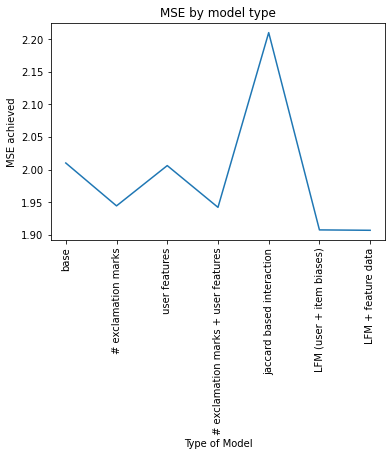

In [38]:
fig, ax = plt.subplots()
ax = sns.lineplot(data=mse_df, x='model_name', y='mse')
ax.set_xticklabels(mse_df['model_name'], rotation = 90)
ax.set(xlabel='Type of Model', ylabel='MSE achieved', title='MSE by model type')
plt.show()

In [40]:
acc_list = [0.13110949461359936, 0.4504832172919048, 0.255533617375039, 0.27396168900897155, 0.7530979658639233, 0.8028472709323773]
model_names = ["base", "# of exclamation marks", "user features", "# exclamation marks + user features", "bag of words on review text", "TF-IDF on review text"]
acc_df= pd.DataFrame({'accuracy': acc_list, 'model_name': model_names})
acc_df

,accuracy,model_name
0,0.131109,base
1,0.450483,# of exclamation marks
2,0.255534,user features
3,0.273962,# exclamation marks + user features
4,0.753098,bag of words on review text
5,0.802847,TF-IDF on review text


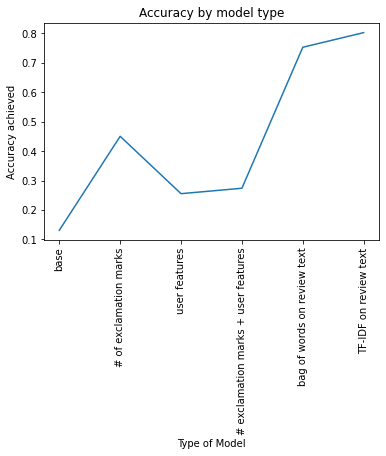

In [41]:
fig, ax = plt.subplots()
ax = sns.lineplot(data=acc_df, x='model_name', y='accuracy')
ax.set_xticklabels(acc_df['model_name'], rotation = 90)
ax.set(xlabel='Type of Model', ylabel='Accuracy achieved', title='Accuracy by model type')
plt.show()

## Fit Prediction

In [42]:
# data[0]

In [29]:
def accuracy(predictions, y):
    correct = predictions == y
    return sum(correct) / len(correct)

def train_and_predict_model(feature_fn):
  # Training/test/validation sets - 70% train, 15% valid, 15% test
  X = [feature_fn(d) for d in data]
  y = [fit_to_float[d['fit']] for d in data]

  Xtrain = X[:7 * len(X) // 10]
  ytrain = y[:7 * len(y) // 10]
  Xvalid = X[7 * len(X) // 10: int(8.5 * len(X) // 10)]
  yvalid = y[7 * len(y) // 10: int(8.5 * len(y) // 10)]
  Xtest = X[int(8.5 * len(X) // 10):]
  ytest = y[int(8.5 * len(y) // 10):]

  # Model creation
  model = linear_model.LogisticRegression(class_weight='balanced')
  model.fit(Xtrain, ytrain)

  # Model validation
  predictions = model.predict(Xvalid)
  print(set(predictions))
  return accuracy(predictions, yvalid)

In [30]:
# Baseline prediction: guess the most common fit seen every time
def feature_base(datum):
  return [1, fit_to_float[most_common_fit]]

In [31]:
acc_base = train_and_predict_model(feature_base)
acc_base

{0}


0.13110949461359936

In [32]:
def feature_1(datum):
  if 'review_text' in datum:
    return [1, datum['review_text'].count('!')]
  return [1, 0]

In [33]:
acc_1 = train_and_predict_model(feature_1)
acc_1

{0, 1}


0.4504832172919048

In [34]:
acc_2 = train_and_predict_model(feature_2)
acc_2

{0, 1, 2}


0.255533617375039

In [35]:
acc_3 = train_and_predict_model(feature_3)
acc_3

{0, 1, 2}


0.27396168900897155

In [36]:
# Bag of words approach for reviews
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1
        
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

words = [x[1] for x in counts[:100]]
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

def feature_bow(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review_text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [37]:
X = [feature_bow(d) for d in data]
y = [fit_to_float[d['fit']] for d in data]

Xtrain = X[:8*len(X)//10]
ytrain = y[:8*len(y)//10]
Xvalid = X[8*len(X)//10:]
yvalid = y[8*len(y)//10:]

# Logistic regressor
clf = linear_model.LogisticRegression()
clf.fit(Xtrain, ytrain)
theta = clf.coef_
predictions = clf.predict(Xvalid)

numCorrect = sum([predictions[i] == yvalid[i] for i in range(len(yvalid))])
acc_bow = numCorrect / len(yvalid)
acc_bow

0.7530979658639233

In [39]:
# TF-IDF approach
corpus = [d["review_text"] for d in data]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

Xtrain = X[:8*X.shape[0]//10]
ytrain = y[:8*len(y)//10]
Xvalid = X[8*X.shape[0]//10:]
yvalid = y[8*len(y)//10:]

# Logistic regressor
clf = linear_model.LogisticRegression()
clf.fit(Xtrain, ytrain)
predictions = clf.predict(Xvalid)

numCorrect = sum([predictions[i] == yvalid[i] for i in range(len(yvalid))])
acc_tfidf = numCorrect / len(yvalid)
acc_tfidf

0.8028472709323773